# Importing required libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
from scipy import sparse
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader,Dataset
warnings.filterwarnings("ignore")

# Importing dataset

We have 4 files in total in the netflix directory, we will now import these 4 files into outr code and combine them into a single file

In [ ]:
full_data = open('data.csv',mode='w')
files=['netflix/combined_data_1.txt','netflix/combined_data_2.txt', 'netflix/combined_data_3.txt', 'netflix/combined_data_4.txt']
for file in files:
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':','')
            else:
                row = [x for x in line.split(',')]
                row.insert(0,movie_id)
                full_data.write(','.join(row))
                full_data.write('\n')
full_data.close()

- We stored the combined data in data.csv file in our project folder
- Now we will create a pandas data frame from our csv file 

In [98]:
full_data = pd.read_csv('data.csv',sep=',',names=['movie_id','user_id','rating','date'])
full_data.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


We will now convert the date column to date type because it is of string type now 

In [99]:
full_data.date = pd.to_datetime(full_data.date,format='%Y-%m-%d')
full_data.sort_values(by='date',inplace=True)

In [100]:
full_data.describe()

,movie_id,user_id,rating,date
count,3.593923e+07,3.593923e+07,3.593923e+07,35939231
mean,3.359009e+03,1.322287e+06,3.595750e+00,2004-10-12 07:56:38.656124928
min,1.000000e+00,6.000000e+00,1.000000e+00,1999-11-11 00:00:00
25%,1.798000e+03,6.608560e+05,3.000000e+00,2004-05-03 00:00:00
50%,3.427000e+03,1.318672e+06,4.000000e+00,2005-01-20 00:00:00
75%,4.996000e+03,1.984358e+06,4.000000e+00,2005-07-05 00:00:00
max,6.386000e+03,2.649429e+06,5.000000e+00,2005-12-31 00:00:00
std,1.863574e+03,7.645951e+05,1.085413e+00,NaN


There are no duplicates/NaN values in the dataset as provided by the netflix

Basic Statistics

In [101]:
print("Total no of ratings :",full_data.shape[0])
print("Total No of Users   :", len(np.unique(full_data.user_id)))
print("Total No of movies  :", len(np.unique(full_data.movie_id)))

Total no of ratings : 35939231
Total No of Users   : 476041
Total No of movies  : 6386


Splitting the Data into train and test splits

In [102]:
train_data = full_data[full_data['user_id'] < 10000]

In [103]:
train_data.shape

(130782, 4)

In [104]:
test_data = full_data[(full_data['user_id'] > 10000) & (full_data['user_id'] < 13000)]

In [105]:
test_data.shape

(43448, 4)

Basic train data statistics

In [106]:
print("Total no of ratings :",train_data.shape[0])
print("Total No of Users   :", len(np.unique(train_data.user_id)))
print("Total No of movies  :", len(np.unique(train_data.movie_id)))

Total no of ratings : 130782
Total No of Users   : 1803
Total No of movies  : 4871


Basic test data statistics

In [107]:
print("Total no of ratings :",test_data.shape[0])
print("Total No of Users   :", len(np.unique(test_data.user_id)))
print("Total No of movies  :", len(np.unique(test_data.movie_id)))

Total no of ratings : 43448
Total No of Users   : 517
Total No of movies  : 3449


# Exploratory Data Analysis

In [108]:
def beautify(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) + " B"

## Histogram of ratings

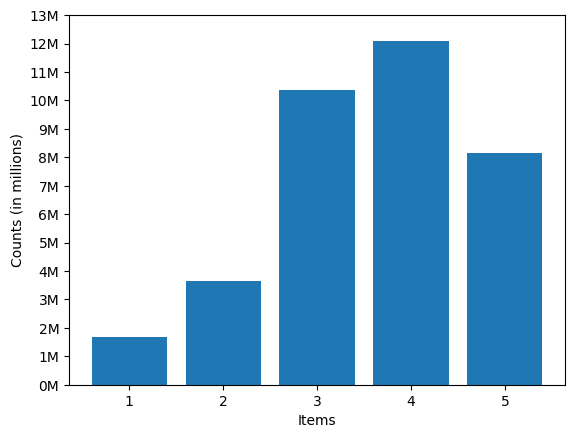

In [109]:
counter = Counter(full_data.rating)
items, counts = zip(*counter.items())
plt.bar(items, counts)
plt.xlabel('Items')
plt.ylabel('Counts (in millions)')
max_count_millions = math.ceil(max(counts) / 1_000_000)
counts_millions = [count / 1_000_000 for count in counts]
plt.yticks([count * 1_000_000 for count in range(0, max_count_millions + 1)], ['{}M'.format(count) for count in range(0, max_count_millions + 1)])

plt.show()

In [110]:
counter

Counter({4: 12080581, 3: 10356248, 5: 8167588, 2: 3664652, 1: 1670162})

We can see that the no.3 and no.4 ratings are more in numbers. We can easily predict that the average rating of all movies will be in between 3 and 4

## No of ratings per month from the beginning of time in dataset to the end

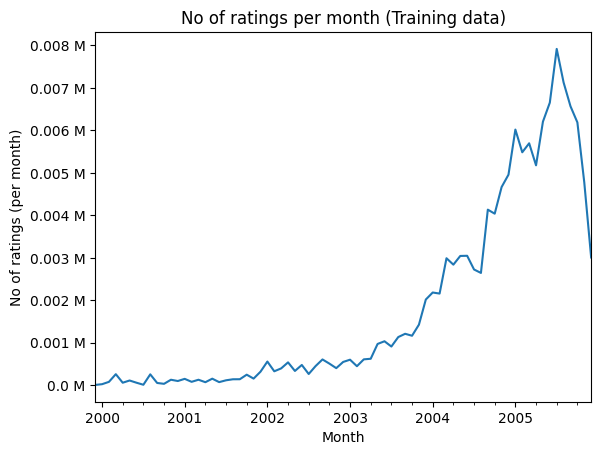

In [111]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
ax = train_data.resample('m')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings (per month)')
ax.set_yticklabels([beautify(item, 'M') for item in ax.get_yticks()])
plt.show()

We have sudden increase in number of movies being rated between start of 2004 and end of 2005 

In [112]:
no_of_rated_movies_per_user = train_data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head(10)

user_id
3321    1565
1333    1087
3998     805
5980     753
4905     689
9557     639
2213     624
4597     622
6629     618
8121     595
Name: rating, dtype: int64

Text(0.5, 1.0, 'PDF')

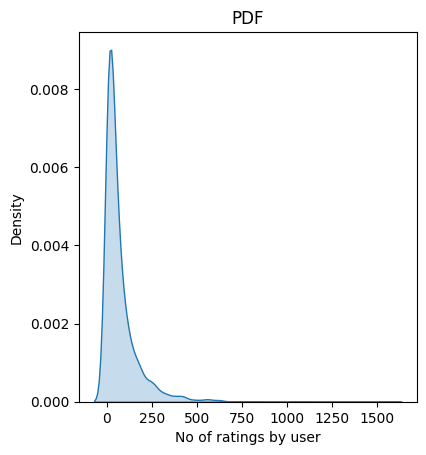

In [113]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

From the above PDF we can see that most number of users rated less than 1000 number of movies and very few users rated more than 1250 movies.

In [114]:
no_of_rated_movies_per_user.describe()

count    1803.000000
mean       72.535774
std       105.776838
min         1.000000
25%        13.000000
50%        36.000000
75%        88.500000
max      1565.000000
Name: rating, dtype: float64

From the above summary statistics we can see that 75% of the users rated about 245 movies. Thats the reason above PDF is skewed.

In [115]:
np.average(train_data.rating)

3.618043767490939

The average rating of all movies is 3.58

# Creating Sparse Matrix

In [116]:
train_sparse = sparse.csr_matrix((train_data.rating.values, (train_data.user_id.values,train_data.movie_id.values)),)
non_zero_tiles = train_sparse.count_nonzero()
a,b = train_sparse.shape
train_sparsity = (1-(non_zero_tiles/(a*b)))*100

In [117]:
print("Sparsity of train matrix : ",train_sparsity)

Sparsity of train matrix :  99.79523720056365


In [118]:
test_sparse = sparse.csr_matrix((test_data.rating.values, (test_data.user_id.values,test_data.movie_id.values)),)
non_zero_tiles = test_sparse.count_nonzero()
a,b = test_sparse.shape
test_sparsity = (1-(non_zero_tiles/(a*b)))*100

In [119]:
print("Sparsity of test matrix : ",test_sparsity)

Sparsity of test matrix :  99.94763630424391


# Cold Start Problem

In [120]:
total_users = len(np.unique(full_data.user_id))
users_train = len(np.unique(train_data.user_id))
new_users = total_users - users_train
print('Total number of Users  :', total_users)
print('Number of Users in Train data :', users_train)
print("No of Users that didn't appear in train data: {}({} %) \n ".format(new_users,np.round((new_users/total_users)*100, 2)))

Total number of Users  : 476041
Number of Users in Train data : 1803
No of Users that didn't appear in train data: 474238(99.62 %) 
 


In [121]:
total_movies = len(np.unique(full_data.movie_id))
movies_train = len(np.unique(train_data.movie_id))
new_movies = total_movies - movies_train
print('Total number of Movies  :', total_movies)
print('Number of movies in Train data :', movies_train)
print("No of movies that didn't appear in train data: {}({} %) \n ".format(new_movies,np.round((new_movies/total_movies)*100, 2)))

Total number of Movies  : 6386
Number of movies in Train data : 4871
No of movies that didn't appear in train data: 1515(23.72 %) 
 


# Similarity techniques

### We are not going to compute user-user similarity matrix as we have 400k users with each user having 17k dimensional vector it takes more time

### Instead we are going to compute the movie-movie similarity matrix which is a (17kx17k) matrix

In [122]:
movie_movie_similarity_matrix = cosine_similarity(train_sparse.T, dense_output=False)
movie_movie_similarity_matrix.setdiag(0)

In [123]:
movie_movie_similarity_matrix.shape

(6387, 6387)

We will now store the top 10 similar movies for each of the 17k movies in a dictionary

In [124]:
similar_movies = {}
all_movies = train_data['movie_id'].unique()
for movie_id in all_movies:
    similar_movies_for_movie_id = movie_movie_similarity_matrix[movie_id].toarray().ravel().argsort()[::-1][1:][:10]
    similar_movies[movie_id] = similar_movies_for_movie_id

In [125]:
movie_titles_master = []
with open('netflix/movie_titles.csv','r') as file:
    for line in file:
        line = line.strip()
        movie_titles_master.append(line)

In [127]:
print("Movie details:")
print(movie_titles_master[294])
print("similar movies to 17692 are:")
for movie_id in similar_movies[295]:
    print(movie_titles_master[movie_id-1])


Movie details:
295,1995,Ace Ventura: When Nature Calls
similar movies to 17692 are:
2095,1997,Liar Liar
2470,1992,Wayne's World
4393,1994,The Mask: Special Edition
6337,2001,Joe Dirt
5472,1987,Spaceballs
3085,2000,Little Nicky
1509,2002,National Lampoon's Van Wilder
4661,1999,Deuce Bigalow: Male Gigolo
2751,1991,Naked Gun 2 1/2: The Smell of Fear
5318,1995,Tommy Boy


In [128]:
print("Movie details:")
print(movie_titles_master[4392])
print("similar movies to 17627 are:")
for movie_id in similar_movies[4393]:
    print(movie_titles_master[movie_id-1])

Movie details:
4393,1994,The Mask: Special Edition
similar movies to 17627 are:
607,1994,Speed
2095,1997,Liar Liar
6350,1998,Rush Hour
2470,1992,Wayne's World
705,1989,Major League
3198,1991,The Addams Family
295,1995,Ace Ventura: When Nature Calls
6196,1984,The Terminator
3648,1988,Who Framed Roger Rabbit?: Special Edition
1659,1993,Grumpy Old Men


In [129]:
print("Movie details:")
print(movie_titles_master[691])
print("similar movies to 9628 are:")
for movie_id in similar_movies[692]:
    print(movie_titles_master[movie_id-1])

Movie details:
692,1992,The Hand that Rocks the Cradle
similar movies to 9628 are:
3782,1990,Flatliners
607,1994,Speed
4330,1995,While You Were Sleeping
2395,1996,Scream
2095,1997,Liar Liar
4256,1984,Footloose: Special Collector's Edition
5628,1996,The Nutty Professor
2594,1989,Look Who's Talking
4705,1987,Overboard
2462,1987,Planes, Trains and Automobiles


In [130]:
print("Movie details:")
print(movie_titles_master[2121])
print("similar movies to 2395 are:")
for movie_id in similar_movies[2122]:
    print(movie_titles_master[movie_id-1])

Movie details:
2122,1999,Being John Malkovich
similar movies to 2395 are:
571,1999,American Beauty
5226,1998,Rushmore
5862,2000,Memento
5926,1999,Fight Club
5614,2000,Best in Show
6029,2001,Amelie
1865,2004,Eternal Sunshine of the Spotless Mind
788,1994,Clerks
175,1992,Reservoir Dogs
6099,1979,Apocalypse Now


We can see that this is a basic algorithm for similarity technique and works good. We will try to build more advanced recommender systems in the upcoming code

# MACHINE LEARNING MODELS

Building train and test sets in Surpise format for surprise models

In [131]:
from surprise import Reader, Dataset,BaselineOnly 

In [132]:
data_reader = Reader(rating_scale=(1,5))
train_dataset = Dataset.load_from_df(train_data[['user_id', 'movie_id', 'rating']],data_reader)
surprise_train_set = train_dataset.build_full_trainset()
surprise_test_set = list(zip(test_data.user_id.values, test_data.movie_id.values, test_data.rating.values))

In [133]:
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

In [134]:
d = {}

# SURPRISE BASE LINE MODEL

In [135]:
surprise_baseline = BaselineOnly(bsl_options = {'method': 'sgd', 'learning_rate': .01})
surprise_baseline.fit(surprise_train_set)
train_preds = surprise_baseline.test(surprise_train_set.build_testset())
train_actual_ratings= np.array([pred.r_ui for pred in train_preds])
train_bsl_pred_ratings = np.array([pred.est for pred in train_preds])
train_rmse, train_mape = get_errors(train_preds)
print("Train Performance Metrics")
print("Train RMSE:",train_rmse,"Train MAPE:",train_mape)
test_preds = surprise_baseline.test(surprise_test_set)
test_actual_ratings= np.array([pred.r_ui for pred in test_preds])
surprise_baseline_test_pred_ratings = np.array([pred.est for pred in test_preds])
test_rmse, test_mape = get_errors(test_preds)
print("Test Performance Metrics")
print("Test RMSE:",test_rmse,"Test MAPE:",test_mape)

d['Baseline'] = {'Train RMSE': 0.9194028262291728, 'Train MAPE': 27.98829708497626 , 'Test RMSE': 0.9968439147788294, 'Test MAPE': 30.640199173819415}

Estimating biases using sgd...


Train Performance Metrics
Train RMSE: 0.9194028262291728 Train MAPE: 27.98829708497626
Test Performance Metrics
Test RMSE: 0.9968439147788294 Test MAPE: 30.640199173819415


# SURPRISE KNN BASELINE ON USER USER SIMILARITY

In [136]:
from surprise import KNNBaseline

In [137]:
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'} 
surprise_knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
surprise_knn_bsl_u.fit(surprise_train_set)
train_preds = surprise_knn_bsl_u.test(surprise_train_set.build_testset())
train_actual_ratings= np.array([pred.r_ui for pred in train_preds])
train_knn_u_pred_ratings = np.array([pred.est for pred in train_preds])
train_rmse, train_mape = get_errors(train_preds)
print("Train Performance Metrics")
print("Train RMSE:",train_rmse,"Train MAPE:",train_mape)
test_preds = surprise_knn_bsl_u.test(surprise_test_set)
test_actual_ratings= np.array([pred.r_ui for pred in test_preds])
surprise_knn_bsl_u_test_pred_ratings = np.array([pred.est for pred in test_preds])
test_rmse, test_mape = get_errors(test_preds)
print("Test Performance Metrics")
print("Test RMSE:",test_rmse,"Test MAPE:",test_mape)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Train Performance Metrics
Train RMSE: 0.450726817425015 Train MAPE: 12.328700243417542
Test Performance Metrics
Test RMSE: 0.9950219958615862 Test MAPE: 30.62410946807211


# SURPRISE KNN BASELINE ON MOVIE MOVIE SIMILARITY

In [138]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              }
bsl_options = {'method': 'sgd'}
surprise_knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
surprise_knn_bsl_m.fit(surprise_train_set)
train_preds = surprise_knn_bsl_m.test(surprise_train_set.build_testset())
train_actual_ratings= np.array([pred.r_ui for pred in train_preds])
train_knn_m_pred_ratings = np.array([pred.est for pred in train_preds])
train_rmse, train_mape = get_errors(train_preds)
print("Train Performance Metrics")
print("Train RMSE:",train_rmse,"Train MAPE:",train_mape)
test_preds = surprise_knn_bsl_m.test(surprise_test_set)
test_actual_ratings= np.array([pred.r_ui for pred in test_preds])
surprise_knn_bsl_m_test_pred_ratings = np.array([pred.est for pred in test_preds])
test_rmse, test_mape = get_errors(test_preds)
print("Test Performance Metrics")
print("Test RMSE:",test_rmse,"Test MAPE:",test_mape)

Estimating biases using sgd...


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Train Performance Metrics
Train RMSE: 0.4708185685302442 Train MAPE: 12.96997557759143
Test Performance Metrics
Test RMSE: 0.9950219958615862 Test MAPE: 30.62410946807211


# MATRIX FACTORIZATION TECHNIQUES

SVD Matrix Factorization

In [139]:
from surprise import SVD

In [140]:
surprise_svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
surprise_svd.fit(surprise_train_set)
train_preds = surprise_svd.test(surprise_train_set.build_testset())
train_actual_ratings= np.array([pred.r_ui for pred in train_preds])
train_svd_pred_ratings = np.array([pred.est for pred in train_preds])
train_rmse, train_mape = get_errors(train_preds)
print("Train Performance Metrics")
print("Train RMSE:",train_rmse,"Train MAPE:",train_mape)
test_preds = surprise_svd.test(surprise_test_set)
test_actual_ratings= np.array([pred.r_ui for pred in test_preds])
surprise_svd_test_pred_ratings = np.array([pred.est for pred in test_preds])
test_rmse, test_mape = get_errors(test_preds)
print("Test Performance Metrics")
print("Test RMSE:",test_rmse,"Test MAPE:",test_mape)

Processing epoch 0
Processing epoch 1


Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Train Performance Metrics
Train RMSE: 0.677443473528694 Train MAPE: 20.26660309849283
Test Performance Metrics
Test RMSE: 0.9938580620026572 Test MAPE: 30.505403653784867


SVD Matrix Factorization with implicit feedback from user

In [141]:
from surprise import SVDpp

In [142]:
surprise_svdpp = SVDpp(n_factors=100, random_state=15, verbose=True)
surprise_svdpp.fit(surprise_train_set)
train_preds = surprise_svdpp.test(surprise_train_set.build_testset())
train_actual_ratings= np.array([pred.r_ui for pred in train_preds])
train_svdpp_pred_ratings = np.array([pred.est for pred in train_preds])
train_rmse, train_mape = get_errors(train_preds)
print("Train Performance Metrics")
print("Train RMSE:",train_rmse,"Train MAPE:",train_mape)
test_preds = surprise_svdpp.test(surprise_test_set)
test_actual_ratings= np.array([pred.r_ui for pred in test_preds])
surprise_svdpp_test_pred_ratings = np.array([pred.est for pred in test_preds])
test_rmse, test_mape = get_errors(test_preds)
print("Test Performance Metrics")
print("Test RMSE:",test_rmse,"Test MAPE:",test_mape)

 processing epoch 0


 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Train Performance Metrics
Train RMSE: 0.5441391507048091 Train MAPE: 15.72906834952557
Test Performance Metrics
Test RMSE: 0.9942700695822917 Test MAPE: 30.490688418774592


# ENSEMBLE MODEL

In [143]:
all_test_predictions = np.array([surprise_baseline_test_pred_ratings,surprise_knn_bsl_u_test_pred_ratings,surprise_knn_bsl_m_test_pred_ratings,surprise_svd_test_pred_ratings,surprise_svdpp_test_pred_ratings])
all_test_preds = np.mean(all_test_predictions,axis=0)
test_actual_ratings

array([3, 3, 3, ..., 5, 5, 4], dtype=int64)

In [144]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_rmse = rmse(test_actual_ratings, all_test_preds)
test_mape = mape(test_actual_ratings, all_test_preds)

print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)

Test RMSE: 0.9939049783542391
Test MAPE: 30.543984512349482


# FEATURIZING THE DATA FOR REGRESSION MODELS

In [145]:
test_data['bsl'] = surprise_baseline_test_pred_ratings
test_data['knn_u'] = surprise_knn_bsl_u_test_pred_ratings
test_data['knn_m'] = surprise_knn_bsl_m_test_pred_ratings
test_data['svd'] = surprise_svd_test_pred_ratings
test_data['svdpp'] = surprise_svdpp_test_pred_ratings

In [146]:
test_data.shape

(43448, 9)

In [147]:
test_data.head()

,movie_id,user_id,rating,date,bsl,knn_u,knn_m,svd,svdpp
13803346,2640,10268,3,2000-01-06,4.079549,4.036668,4.036668,3.932473,3.804996
5894733,1157,10268,3,2000-01-06,3.362539,3.427967,3.427967,3.448295,3.422181
4698159,931,10268,3,2000-01-06,3.280227,3.402718,3.402718,3.435544,3.405568
29713806,5444,10268,2,2000-01-06,3.441228,3.518444,3.518444,3.539112,3.516245
35113306,6285,10268,3,2000-01-06,3.358916,3.446778,3.446778,3.454049,3.437214


In [148]:
train_data['bsl'] = train_bsl_pred_ratings
train_data['knn_u'] = train_knn_u_pred_ratings
train_data['knn_m'] = train_knn_m_pred_ratings
train_data['svd'] = train_svd_pred_ratings
train_data['svdpp'] = train_svdpp_pred_ratings

In [149]:
train_data.shape

(130782, 8)

In [150]:
train_data.head()

,movie_id,user_id,rating,bsl,knn_u,knn_m,svd,svdpp
date,,,,,,,,
1999-12-31,295,1086,4,3.186765,3.365851,3.348955,2.959398,3.147548
1999-12-31,4652,1086,3,3.097945,3.155964,3.281321,3.071056,3.122768
1999-12-31,829,1086,3,3.157202,3.229965,3.283076,3.019874,3.084087
1999-12-31,5237,1086,5,3.237026,3.907288,4.018165,3.694763,4.026036
1999-12-31,682,1086,4,3.865532,3.924292,3.955110,3.907480,4.029154


In [151]:
global_user_avg = test_data.groupby('user_id')['rating'].mean()
global_movie_avg = test_data.groupby('movie_id')['rating'].mean()
test_data['global_avg_user_rating'] = test_data['user_id'].map(global_user_avg)
test_data['global_avg_movie_rating'] = test_data['movie_id'].map(global_movie_avg)

In [152]:
global_user_avg = train_data.groupby('user_id')['rating'].mean()
global_movie_avg = train_data.groupby('movie_id')['rating'].mean()
train_data['global_avg_user_rating'] = train_data['user_id'].map(global_user_avg)
train_data['global_avg_movie_rating'] = train_data['movie_id'].map(global_movie_avg)

In [153]:
train_data.head()

,movie_id,user_id,rating,bsl,knn_u,knn_m,svd,svdpp,global_avg_user_rating,global_avg_movie_rating
date,,,,,,,,,,
1999-12-31,295,1086,4,3.186765,3.365851,3.348955,2.959398,3.147548,3.56,3.447619
1999-12-31,4652,1086,3,3.097945,3.155964,3.281321,3.071056,3.122768,3.56,3.083333
1999-12-31,829,1086,3,3.157202,3.229965,3.283076,3.019874,3.084087,3.56,3.166667
1999-12-31,5237,1086,5,3.237026,3.907288,4.018165,3.694763,4.026036,3.56,3.295918
1999-12-31,682,1086,4,3.865532,3.924292,3.955110,3.907480,4.029154,3.56,3.846154


In [154]:
test_data.head()

,movie_id,user_id,rating,date,bsl,knn_u,knn_m,svd,svdpp,global_avg_user_rating,global_avg_movie_rating
13803346,2640,10268,3,2000-01-06,4.079549,4.036668,4.036668,3.932473,3.804996,3.177305,3.222222
5894733,1157,10268,3,2000-01-06,3.362539,3.427967,3.427967,3.448295,3.422181,3.177305,2.000000
4698159,931,10268,3,2000-01-06,3.280227,3.402718,3.402718,3.435544,3.405568,3.177305,3.000000
29713806,5444,10268,2,2000-01-06,3.441228,3.518444,3.518444,3.539112,3.516245,3.177305,2.666667
35113306,6285,10268,3,2000-01-06,3.358916,3.446778,3.446778,3.454049,3.437214,3.177305,3.000000


In [155]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [156]:
y_train = train_data['rating']
X_train = train_data.drop(columns=['rating'])
y_test = test_data['rating']
X_test = test_data.drop(columns=['rating'])

In [157]:
X_test.head()

,movie_id,user_id,date,bsl,knn_u,knn_m,svd,svdpp,global_avg_user_rating,global_avg_movie_rating
13803346,2640,10268,2000-01-06,4.079549,4.036668,4.036668,3.932473,3.804996,3.177305,3.222222
5894733,1157,10268,2000-01-06,3.362539,3.427967,3.427967,3.448295,3.422181,3.177305,2.000000
4698159,931,10268,2000-01-06,3.280227,3.402718,3.402718,3.435544,3.405568,3.177305,3.000000
29713806,5444,10268,2000-01-06,3.441228,3.518444,3.518444,3.539112,3.516245,3.177305,2.666667
35113306,6285,10268,2000-01-06,3.358916,3.446778,3.446778,3.454049,3.437214,3.177305,3.000000


# XGBoost

Optimal Parameters :  {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 70, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 15, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


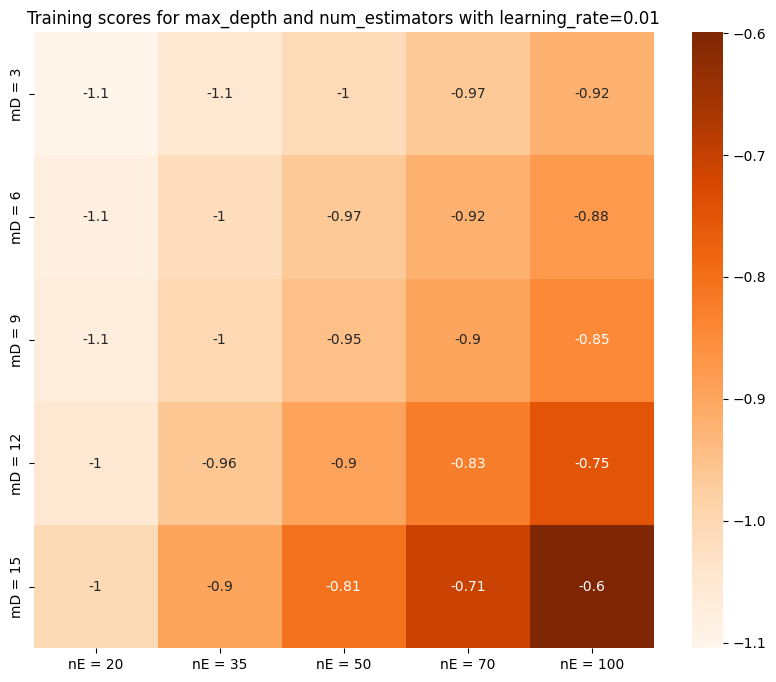

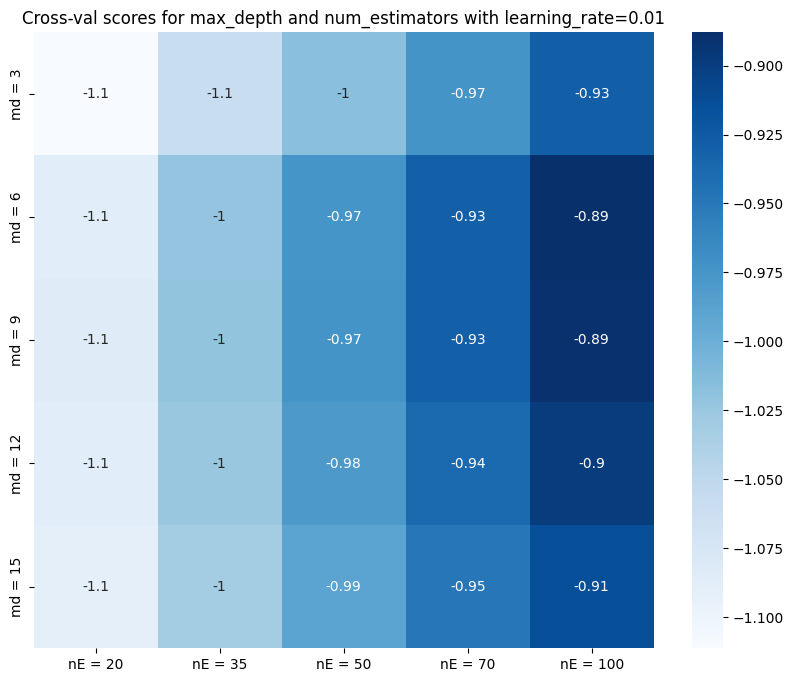

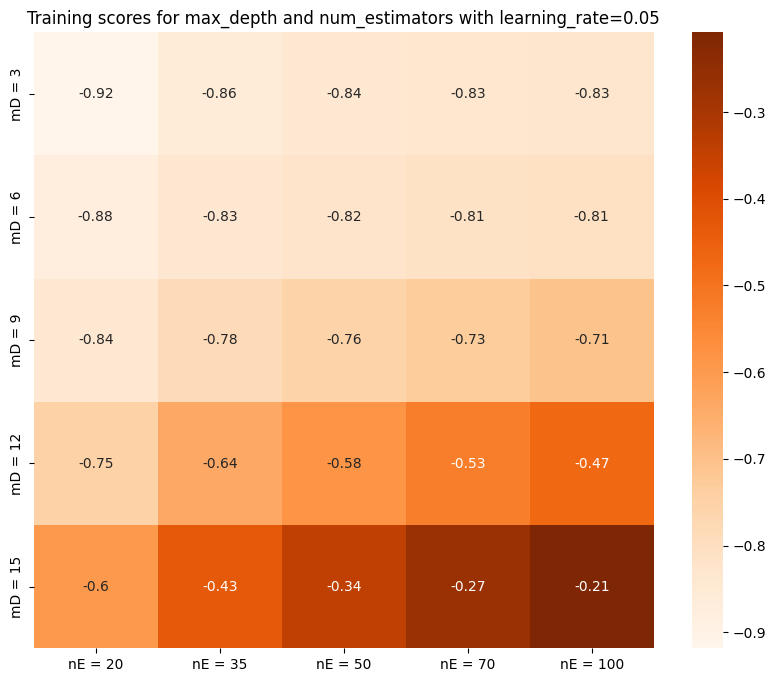

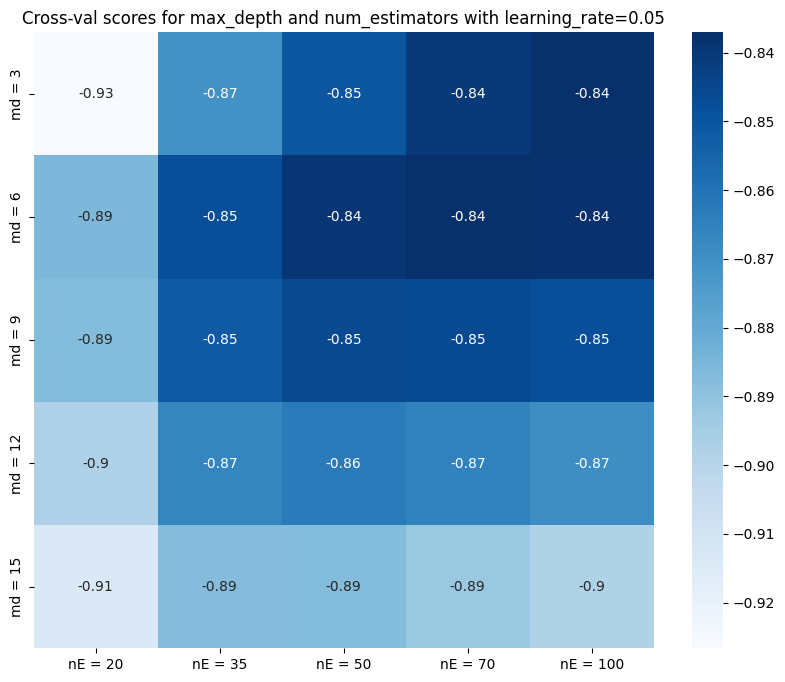

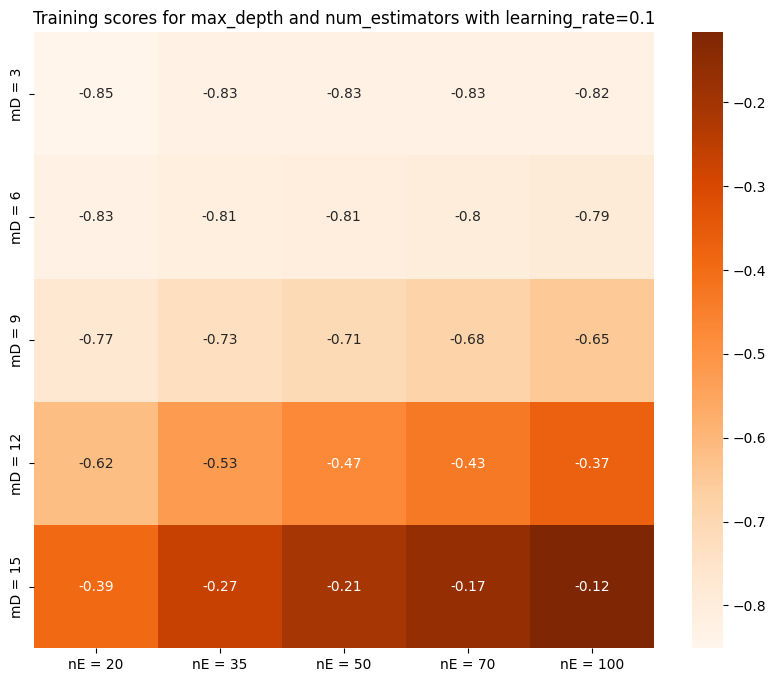

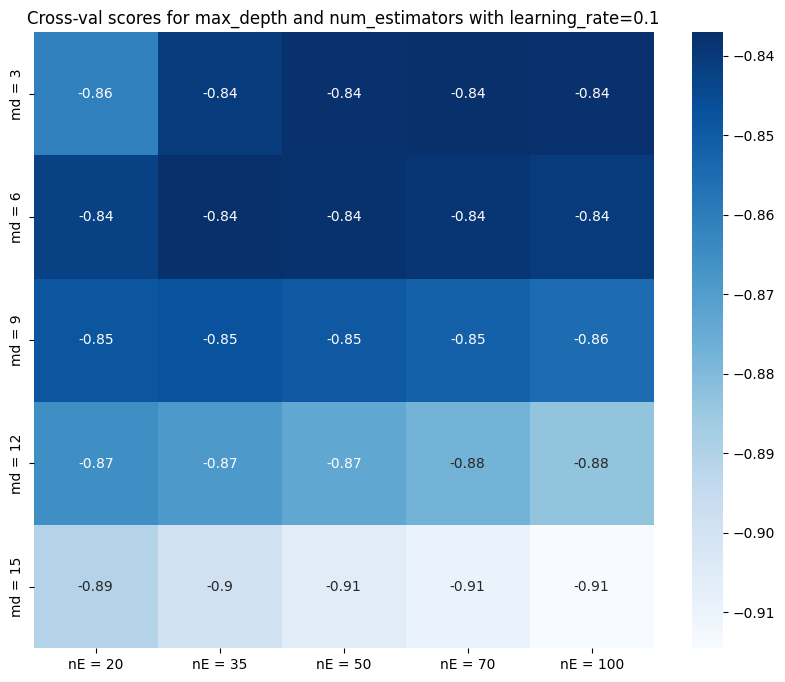

In [158]:
max_depth = np.array([3, 6, 9, 12, 15])
learning_rate = np.array([0.01, 0.05, 0.1])
n_estimators = np.array([20, 35, 50, 70, 100])
params_dict = [{'max_depth': max_depth,'learning_rate': learning_rate,
'n_estimators': n_estimators}]
xgb_optimal = xgb.XGBRegressor(random_state=15,n_jobs=-1)
grid = GridSearchCV(estimator=xgb_optimal,
                    param_grid=params_dict,
                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5,
                    return_train_score=True)
grid_result = grid.fit(X_train, y_train)
train_score = grid_result.cv_results_['mean_train_score']
train_score_std = grid_result.cv_results_['std_train_score']
cv_score = grid_result.cv_results_['mean_test_score']
cv_score_std = grid_result.cv_results_['std_test_score']
print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
train_score = train_score.reshape(len(learning_rate),len(max_depth),
                                  len(n_estimators))
cv_score = cv_score.reshape(len(learning_rate),len(max_depth),
                                  len(n_estimators))
for lr in range(len(learning_rate)):
    plt.figure(figsize=(10.0, 8.0))
    ax = sns.heatmap(train_score[lr,:,:],
                annot=True, square=False, cmap="Oranges",
                xticklabels=["nE = "+str(ne) for ne in n_estimators],
                yticklabels=["mD = "+str(md) for md in max_depth])
    
    plt.title("Training scores for max_depth and num_estimators "+
                "with learning_rate="+str(learning_rate[lr]))
    plt.show()
    print('')
    plt.figure(figsize=(10.0, 8.0))
    ax = sns.heatmap(cv_score[lr,:,:],
                annot=True, square=False, cmap="Blues",
                xticklabels=["nE = "+str(ne) for ne in n_estimators],
                yticklabels=["md = "+str(md) for md in max_depth])
    plt.title("Cross-val scores for max_depth and num_estimators "+
                "with learning_rate="+str(learning_rate[lr]))
    plt.show()

In [159]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [160]:
X_test = X_test.drop(['date'],axis=1)

In [161]:
xgb_optimal = xgb.XGBRegressor(max_depth=6,
                              learning_rate=0.05,
                              n_estimators=70,
                              n_jobs=-1,random_state=15)
    
xgb_optimal.fit(X_train, y_train)
pred_train = xgb_optimal.predict(X_train)
pred_test = xgb_optimal.predict(X_test)
print("Using max depth value for tree - ",6)
print("Using num estimators for tree - ", 70)
print("Using learning rate for tree - ", 0.05)

train_rmse, train_mape = get_error_metrics(y_train, pred_train)
print("Train Error Metrics. \n\tRMSE: {}\n\tMAPE: {}".
      format(train_rmse, train_mape))
test_rmse, test_mape = get_error_metrics(np.array(y_test),np.array(pred_test))
print("Test Error Metrics. \n\tRMSE: {}\n\tMAPE: {}". 
      format(test_rmse, test_mape))

Using max depth value for tree -  6
Using num estimators for tree -  70
Using learning rate for tree -  0.05
Train Error Metrics. 
	RMSE: 0.9032830684516676
	MAPE: 27.527433383281476
Test Error Metrics. 
	RMSE: 0.8637764269642914
	MAPE: 25.15808375618946


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

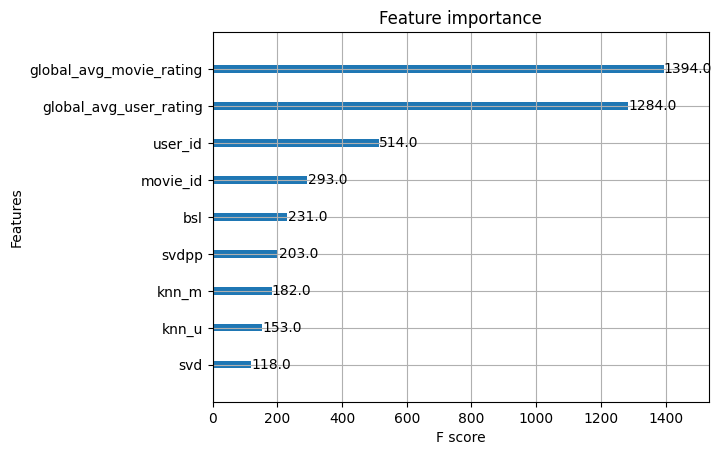

In [162]:
xgb.plot_importance(xgb_optimal)

In [163]:
d = {}
d['Baseline'] = {'Train RMSE': 0.9194028262291728, 'Train MAPE': 27.98829708497626 , 'Test RMSE': 0.9968439147788294, 'Test MAPE': 30.640199173819415}
d['KNN u-u'] = {'Train RMSE': 0.450726817425015 ,'Train MAPE': 12.328700243417542,'Test RMSE': 0.9950219958615862 ,'Test MAPE': 30.62410946807211}
d['knn m-m'] = {'Train RMSE': 0.4708185685302442, 'Train MAPE': 12.96997557759143 , 'Test RMSE': 0.9950219958615862 ,'Test MAPE': 30.62410946807211}
d['svd'] = {'Train RMSE': 0.677443473528694 ,'Train MAPE': 20.26660309849283 , 'Test RMSE': 0.9938580620026572 ,'Test MAPE': 30.505403653784867}
d['svdpp'] = {'Train RMSE': 0.5441391507048091 ,'Train MAPE': 15.72906834952557 ,'Test RMSE': 0.9942700695822917 ,'Test MAPE': 30.490688418774592}
d['xgb+surprise'] = {'Train RMSE':0.9032830684516676,'Train MAPE':27.527433383281476,'Test RMSE':0.8637764269642914,'Test MAPE':25.15808375618946}

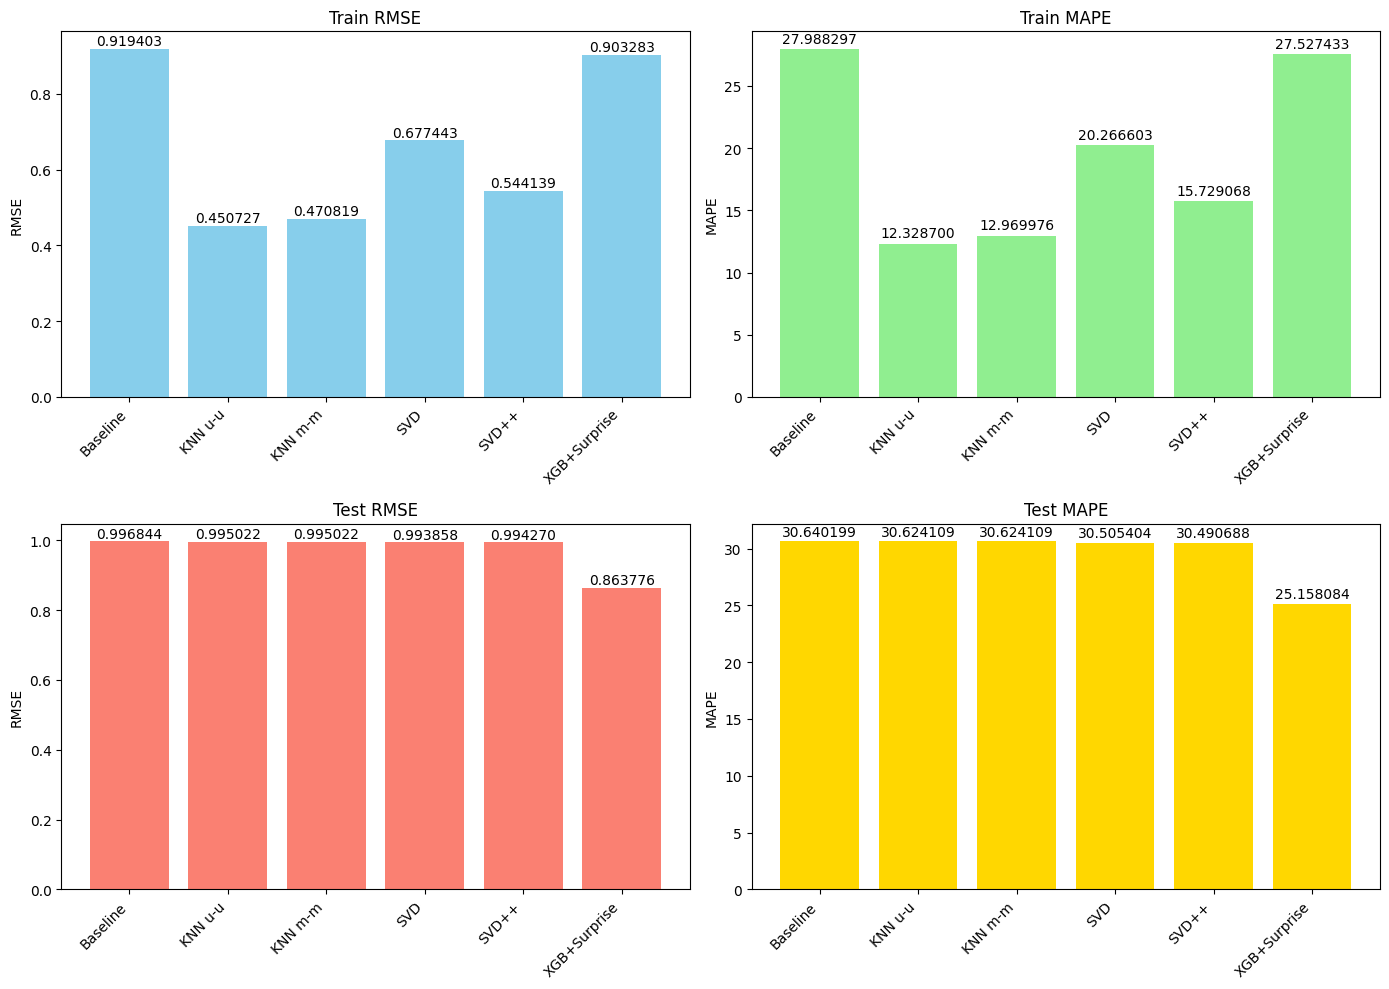

In [164]:
import matplotlib.pyplot as plt

# Define the data
models = ['Baseline', 'KNN u-u', 'KNN m-m', 'SVD', 'SVD++', 'XGB+Surprise']
train_rmse = [0.9194028262291728, 0.450726817425015, 0.4708185685302442, 0.677443473528694, 0.5441391507048091, 0.9032830684516676]
train_mape = [27.98829708497626, 12.328700243417542, 12.96997557759143, 20.26660309849283, 15.72906834952557, 27.527433383281476]
test_rmse = [0.9968439147788294, 0.9950219958615862, 0.9950219958615862, 0.9938580620026572, 0.9942700695822917, 0.8637764269642914]
test_mape = [30.640199173819415, 30.62410946807211, 30.62410946807211, 30.505403653784867, 30.490688418774592, 25.15808375618946]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Train RMSE
axs[0, 0].bar(models, train_rmse, color='skyblue')
axs[0, 0].set_title('Train RMSE')
axs[0, 0].set_ylabel('RMSE')
for i, v in enumerate(train_rmse):
    axs[0, 0].text(i, v + 0.01, f'{v:.6f}', ha='center')

# Train MAPE
axs[0, 1].bar(models, train_mape, color='lightgreen')
axs[0, 1].set_title('Train MAPE')
axs[0, 1].set_ylabel('MAPE')
for i, v in enumerate(train_mape):
    axs[0, 1].text(i, v + 0.5, f'{v:.6f}', ha='center')

# Test RMSE
axs[1, 0].bar(models, test_rmse, color='salmon')
axs[1, 0].set_title('Test RMSE')
axs[1, 0].set_ylabel('RMSE')
for i, v in enumerate(test_rmse):
    axs[1, 0].text(i, v + 0.01, f'{v:.6f}', ha='center')

# Test MAPE
axs[1, 1].bar(models, test_mape, color='gold')
axs[1, 1].set_title('Test MAPE')
axs[1, 1].set_ylabel('MAPE')
for i, v in enumerate(test_mape):
    axs[1, 1].text(i, v + 0.5, f'{v:.6f}', ha='center')

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(models, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
